In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import re

In [2]:
df = pd.read_csv('../data/raw_data_20_10_21.csv')

In [3]:
len(df)  # 370 rows supposed to correspond to a job

322

In [4]:
len(pd.unique(df.description))  # only 236 unique job descriptions so there must be duplicates in the data

241

### Deletion of duplicates 

In [5]:
# Find a duplicate rows
duplicateDFRow = df[df.duplicated()]
len(duplicateDFRow)  # there are 133 duplicated in the data

78

In [6]:
df.drop(duplicateDFRow.index, inplace=True)
len(df)

244

In [7]:
df.head()

,title,company,city,contract_type,salary,description,link
0,Data Scientist,Avisto,06220 Vallauris,"Temps plein, CDI",-,"Dans le cadre de nos activités, vous serez ame...",https://fr.indeed.com/rc/clk?jk=a633bad2a5d6f5...
1,Data scientist F/H,Opteven,Villeurbanne (69),CDI,-,Pour accompagner sa croissance et son évolutio...,https://fr.indeed.com/company/Opteven/jobs/Dat...
2,CDI - Data Scientist - Yves Rocher F/H,Groupe Yves Rocher,Rennes (35),CDI,-,"Réf: 95202\n\nLieu:\nFR - Rennes, FR\n\nType d...",https://fr.indeed.com/rc/clk?jk=5c886be0ff3794...
3,Data Scientist - Demande de dérogation recrute...,Safran,Magny-les-Hameaux (78),-,-,Safran est un groupe international de haute te...,https://fr.indeed.com/rc/clk?jk=471597dc13ddc2...
4,INGENIEUR DATA SCIENTIST F/H,PROBAYES,Paris 15e (75),"Apprentissage, Contrat pro",-,Descriptif du poste:\nIngénieur Machine Learni...,https://fr.indeed.com/rc/clk?jk=778d77eabbab03...


### City 

In [8]:
pd.unique(df.city)

array(['06220 Vallauris', 'Villeurbanne (69)', 'Rennes (35)',
       'Magny-les-Hameaux (78)', 'Paris 15e (75)', 'Paris (75)',
       '92400 Courbevoie', '06560 Valbonne', '94300 Vincennes',
       'La Défense (92)', '92100 Boulogne-Billancourt', 'Toulouse (31)',
       'Paris 8e (75)', '92700 Colombes', 'Neuilly-sur-Seine (92)',
       '47000 Agen', 'Montpellier (34)', 'Lille (59)', 'Nice (06)',
       'Télétravail', '34095 Montpellier', 'Lyon (69)',
       '17000 La Rochelle', 'Vitry-sur-Seine (94)', '92037 La Défense',
       'Paris 20e (75)', '75001 Paris', 'Tours (37)', '92800 Puteaux',
       '92300 Levallois-Perret', '75009 Paris 9e', '91940 Les Ulis',
       '37000 Tours', 'Meudon (92)', 'Eu (76)', 'Gif-sur-Yvette (91)',
       'Amiens (80)', 'Gennevilliers (92)', 'Paris 2e (75)', '14000 Caen',
       '31300 Toulouse', 'Aix-en-Provence (13)', '34000 Montpellier',
       'Clichy (92)', '78533 Buc', 'Brétigny-sur-Orge (91)',
       'Nanterre (92)', 'Illkirch-Graffenstaden (67)', 

If postal code is given, we want to keep it in another variable

In [11]:
postal_codes_re = r"([0-9]{5})"  # matching and capturing a group of 5 figures
df['postal_code'] = df.city.str.extract(postal_codes_re, flags = re.M)  # in the city variable, extract postal code if present

#### Cities with districts 

For cities with districts (Paris, Lyon, Marseille), we want to grab it if it's given after the name of the city, for example 'Paris 2e'

In [54]:
districts_re = r"(?P<city>paris|marseille|lyon) (?P<district>[0-9]+)e"  # ?P<> enables to name capturing groups
district_df = df.city.str.extract(districts_re, flags=re.I | re.M)  # 1st column : city name if matched, 2nd : district

In [56]:
df['district'] = district_df.district  # add the district information in the dataframe

In [59]:
def postal_codes_w_districts(df):
    # Updates the postal code column with information from the district, for Paris, Lyon, Marseille
    # params:
    # - df is the dataframe containing at least the columns district, city, and postal code
    # return :
    # the same df with updated postal codes
    
    nb_char_district = df['district'].str.len()  # compute length of the district, to create postal code
    
    # Paris
    paris_data = df.loc[df.city.str.contains('Paris', case=False)]
    one_figure_district = paris_data.loc[nb_char_district==1]
    df.loc[one_figure_district.index, 'postal_code'] = '7500' + one_figure_district.district
    
    two_figure_district = paris_data.loc[nb_char_district==2]
    df.loc[two_figure_district.index, 'postal_code'] = '750' + two_figure_district.district
    
    # Marseille
    marseille_data = df.loc[df.city.str.contains('Marseille', case=False)]
    one_figure_district = marseille_data.loc[nb_char_district==1]
    df.loc[one_figure_district.index, 'postal_code'] = '1300' + one_figure_district.district
    
    two_figure_district = marseille_data.loc[nb_char_district==2]
    df.loc[two_figure_district.index, 'postal_code'] = '130' + two_figure_district.district
    
    # Lyon - only 9 districts in this city
    lyon_data = df.loc[df.city.str.contains('Lyon', case=False)]
    one_figure_district = lyon_data.loc[nb_char_district==1]
    df.loc[one_figure_district.index, 'postal_code'] = '6900' + one_figure_district.district
    
    return(df)

In [61]:
df = postal_codes_w_districts(df)

#### Clean the city variable

We want to clean the city variable by removing the postal code data and keeping only the city name \
We do this by keeping only the characters that are 
 - letters
 - '-' sign
 - apostrophe

In [759]:
# takes a string and returns the same strings but only with characters that are letters (or - sign)
def get_letters(value):
    return ''.join([i for i in value if (i.isalpha()) | (i=='-') | (i==' ') | (i=="'")])

In [760]:
#clean the city variable, by removing the postal codes or parentheses
df['city_letters'] = df.city.apply(get_letters)

In [764]:
pd.unique(df.city_letters)

array(['Vallauris', 'Villeurbanne', 'Rennes', 'Magny-les-Hameaux',
       'Paris', 'Courbevoie', 'Valbonne', 'Vincennes', 'La Défense',
       'Boulogne-Billancourt', 'Toulouse', 'Colombes',
       'Neuilly-sur-Seine', 'Agen', 'Montpellier', 'Lille', 'Nice',
       'Télétravail', 'Lyon', 'La Rochelle', 'Vitry-sur-Seine', 'Tours',
       'Puteaux', 'Levallois-Perret', 'Les Ulis', 'Meudon', 'Eu',
       'Gif-sur-Yvette', 'Amiens', 'Gennevilliers', 'Caen',
       'Aix-en-Provence', 'Clichy', 'Buc', 'Brétigny-sur-Orge',
       'Nanterre', 'Illkirch-Graffenstaden', 'Wissous', 'Annecy',
       'La Roche-sur-Yon', 'Bordes', 'Strasbourg', 'Châtellerault',
       'Bondoufle', 'Lezennes', 'Bordeaux', 'Montrouge', 'Bagneux',
       'Marseille', 'Don', 'Hem', 'Le Bar-sur-Loup', 'Montreuil',
       'Nantes', 'Charenton-le-Pont', 'Nogent-sur-Marne', 'Ormes',
       'Issy-les-Moulineaux', 'Valenciennes', 'Vanves', 'Steinbourg',
       'Saclay', 'Roanne', 'Saint-Sauveur', 'Lavaur', 'Aytré',
       'Le

With cities with districts, we lost this information but letters can still be in the city name \
For these cities, we fix it by replacing by the name of the city when it's found in the variable

In [762]:
# Paris
paris_indices = df.loc[df.city_letters.str.contains('Paris', case=False)].index
df.loc[paris_indices, "city_letters"] = ["Paris"]*len(paris_indices)

# Marseille
marseille_indices = df.loc[df.city_letters.str.contains('Marseille', case=False)].index
df.loc[marseille_indices, "city_letters"] = ["Marseille"]*len(marseille_indices)

# Lyon
lyon_indices = df.loc[df.city_letters.str.contains('Lyon', case=False)].index
df.loc[lyon_indices, 'city_letters'] = ["Lyon"]*len(lyon_indices)

In [763]:
# city that starts or ends with a space --> we remove this space
# ^\s for start
# \s$ for end with a space
df.city_letters.replace('^\s','',regex=True, inplace = True)
df.city_letters.replace('\s$', '', regex=True, inplace=True)

### Contract type 

In [534]:
pd.unique(df.contract_type)

array(['CDI', '-', ' -  Temps plein, CDI', 'Temps plein, CDI',
       'Apprentissage, Contrat pro', 'Stage', 'CDD', 'CDD, CDI',
       'Temps plein, Stage', 'Temps partiel',
       'Temps plein, Temps partiel', ' -  Temps plein, CDD',
       'Freelance / Indépendant', 'Temps plein, CDD', ' -  CDI',
       ' -  Intérim', 'Temps plein, Intérim', 'Intérim'], dtype=object)

#### CDI 

In [535]:
cdi_indices = df.loc[df['contract_type'].str.contains("CDI", case=False)].index
df.loc[cdi_indices, "contract_type"] = ["CDI"]*len(cdi_indices)

#### Apprentissage

In [536]:
student_indices = df.loc[(df['contract_type'].str.contains("Apprentissage", case=False)) | df.contract_type.str.contains("Stage", case=False)].index
df.drop(student_indices, inplace=True)  # we are not interested in this type of contract, 34 rowd

#### Intérim

In [537]:
interim_indices = df.loc[df['contract_type'].str.contains("Intérim", case=False)].index
df.loc[interim_indices, "contract_type"] = ["Intérim"]*len(interim_indices)

In [538]:
pd.unique(df.contract_type)

array(['CDI', '-', 'CDD', 'Temps partiel', 'Temps plein, Temps partiel',
       ' -  Temps plein, CDD', 'Freelance / Indépendant',
       'Temps plein, CDD', 'Intérim'], dtype=object)

#### CDD

In [539]:
cdd_indices = df.loc[df['contract_type'].str.contains("CDD", case=False)].index
df.loc[cdd_indices, 'contract_type'] = ["CDD"]*len(cdd_indices)

In [540]:
# lines where it's not specified will be represented with '-'
unspec_indices = df.loc[df.contract_type.str.contains("Temps partiel", case=False)].index
df.loc[unspec_indices, 'contract_type'] = ["-"]*len(unspec_indices)

#### Freelance 

In [541]:
# as I'm searching for a first job, I am not looking at freelandce opportunities
freelance_indices = df.loc[df.contract_type.str.contains("Freelance", case=False)].index
df.drop(freelance_indices, inplace=True)

### Salary 

In [542]:
pd.unique(df.salary)

array(['-', '40\xa0000 € par an', '2\xa0750 € par mois',
       '3\xa0000 € par mois', '38\xa0000 € par an',
       '50\xa0000 € - 60\xa0000 € par an',
       '2\xa0053 € - 4\xa0211 € par mois',
       '36\xa0000 € - 38\xa0000 € par an',
       '40\xa0000 € - 55\xa0000 € par an',
       '35\xa0000 € - 40\xa0000 € par an',
       '35\xa0000 € - 38\xa0000 € par an',
       '30\xa0000 € - 40\xa0000 € par an',
       '50\xa0000 € - 80\xa0000 € par an',
       '45\xa0000 € - 55\xa0000 € par an',
       '35\xa0000 € - 45\xa0000 € par an', '550 € - 600 € par jour',
       '40\xa0000 € - 50\xa0000 € par an', '3\xa0624 € par mois',
       '60\xa0000 € - 70\xa0000 € par an', '3\xa0300 € par mois',
       '38\xa0000 € - 45\xa0000 € par an', '36\xa0731 € par an',
       '55\xa0000 € - 65\xa0000 € par an', '200 € - 400 € par jour',
       '200 € - 430 € par jour'], dtype=object)

Most salaries are not fixed, but an interval is given \
To be able to compare salaries, we will replace it by the interval mean \
We will also convert monthly salaries to yearly

#### From monthly to yearly 

In [543]:
# when salary is given per month, we want to calculate it by year
month_salary_info = df.loc[df.salary.str.contains('par mois', case=False)].salary

In [544]:
# takes a string and returns the same strings but only with characters that are numeric
def get_numbers(value):
    return ''.join([i for i in value if i.isnumeric()])

In [545]:
def get_interval_mean(value):
    # value is a string containing a salary interval, e.g. "30 000 € - 40 000 €"
    
    res = value.split('-')
    first = int(get_numbers(res[0]))
    last = int(get_numbers(res[1]))
    return (first+last)/2

In [546]:
def monthly_to_annual(value):
    if '-' in value:
        return str(get_interval_mean(value)*12)
    else:  # salary is fixed
        return str(int(get_numbers(value))*12)

In [547]:
month_salary_info = month_salary_info.apply(monthly_to_annual)

# replace in the dataframe
df.loc[month_salary_info.index, "salary"] = month_salary_info

In [548]:
print(pd.unique(df.salary))

['-' '40\xa0000 € par an' '33000' '36000' '38\xa0000 € par an'
 '50\xa0000 € - 60\xa0000 € par an' '37584.0'
 '36\xa0000 € - 38\xa0000 € par an' '40\xa0000 € - 55\xa0000 € par an'
 '35\xa0000 € - 40\xa0000 € par an' '35\xa0000 € - 38\xa0000 € par an'
 '30\xa0000 € - 40\xa0000 € par an' '50\xa0000 € - 80\xa0000 € par an'
 '45\xa0000 € - 55\xa0000 € par an' '35\xa0000 € - 45\xa0000 € par an'
 '550 € - 600 € par jour' '40\xa0000 € - 50\xa0000 € par an' '43488'
 '60\xa0000 € - 70\xa0000 € par an' '39600'
 '38\xa0000 € - 45\xa0000 € par an' '36\xa0731 € par an'
 '55\xa0000 € - 65\xa0000 € par an' '200 € - 400 € par jour'
 '200 € - 430 € par jour']


#### Daily salary 

In [549]:
# when salary is daily, it is a freelance contract, that wasn't specified in the contract type variable
# so we drop ir
daily_indices = df.loc[df.salary.str.contains('par jour', case=False)].index
df.drop(daily_indices, inplace=True)

#### From interval to mean for the salaries that were given yearly

In [550]:
# salaries that contain 'par an' have not been touched yet
annual_to_clean = df.loc[df.salary.str.contains('par an', case=False)].salary

In [551]:
def clean_annual_salary(value):

    if '-' in value:  # salary is given as an interval
        return str(get_interval_mean(value))
    else:  # salary is fixed
        return get_numbers(value)

In [552]:
annual_to_clean = annual_to_clean.apply(clean_annual_salary)
df.loc[annual_to_clean.index, 'salary'] = annual_to_clean

### Job title 

In [ ]:
pd.unique(df.title)
# offers to drop : 
# Senior
# Principal
# Docteur
# PhD
# Lead
# freelance
# apprenticeship
# responsable
# postdoctoral, chef de projet, directeur

In [554]:
drop_titles =['senior', 'principal', 'docteur', 'phd', 'lead', 'freelance', 'apprenticeship',
             'responsable', 'postdoctoral', 'chef de projet', 'directeur']

pattern = '|'.join(drop_titles)

drop_titles_indices = df.loc[df['title'].str.contains(pattern, case=False)].index
df.drop(drop_titles_indices, inplace=True)

### Clean the description 

In [555]:
def clean_description(value):
    # value is a string containing description
    
    res = ' '.join(value.split('\n'))
    return res

In [556]:
df['description_clean'] = df.description.apply(clean_description)

### Skills

Using the job description, we will build binary variables that will indicate for each skill if it is required for the job

In [557]:
skills = ['bi', 'datavisualisation', 'statistique', 'machine learning', 'reporting', 'big data', 'cnn', 'knn',
         'dashboard', 'anglais', 'apprentissage par renforcement', 'reinforcment learning', 'IA', 'deep learning',
         "traitement d'images", 'agile', 'time series', 'séries temporelles', 'graph', 'supervisé', 'non supervisé',
          "reconnaissance d'images", 'nlp', 'natural language processing', 'classification', 'optimisation',
          'prédiction', 'elasticsearch', 'kibana', 'xgboost', 'données géographiques', 'ocr', 'bayesian', 'bayes',
          'random forest', 'neural network', 'réseau de neurones', 'computer vision', 'a/b', 'data mining'
         ]

tools = ['r', 'python', 'julia', 'power bi', 'sql', 'tableau software', 'qlik', 'pack office', 'pandas',
        'sas', 'scikit-learn', 'sklearn', 'tensorflow', 'keras', 'C++', 'git', 'airflow', 'mongodb', 'VBA', 'java',
         'linux', 'scala', 'pytorch', 'keras', 'numpy', 'gensim', 'cloud', 'hadoop', 'pyspark', 'docker', 'aws',
         'nosql', 'matlab', 'matplotlib', 'jupyter', 'shiny', 'knitr', 'caret', 'plotly', 'mlr', 'dplyr', 'dash'
        ]

In [558]:
# add a binary column per skill
for i in range(len(skills)):
    newvar = df.description_clean.str.contains(skills[i], case=False)
    df[f'{skills[i]}'] = newvar

In [559]:
# add a binary column per tool
for i in range(len(tools)):
    if tools[i]=="C++":
        newvar = df.description_clean.str.contains(re.escape(tools[i]), case=False)
    else:
        newvar = df.description_clean.str.contains(tools[i], case=False)
    df[f'{tools[i]}'] = newvar

### Find sub groups of jobs (DS, DA...) 

In [560]:
job_cat = ['data scientist', 'data analyst', 'data engineer']
# add a binary column per category
for i in range(len(job_cat)):
    newvar = df.title.str.contains(job_cat[i], case=False)
    df[f'{job_cat[i]}'] = newvar

### Degree level 

In [573]:
# we use regex to deal with accents etc
degree_dict = {'master':2, '[ée]cole.*ing[ée]nieur':2, 'licence':1, 'DUT':1, 'bac[ ]*\+4':2,
              'bac[ ]*\+5':2, 'bac[ ]*\+3':1}

In [574]:
# add the new column with entry 3 for each row, which will correspond to the value if no degree is specified
df['degree_level'] = [3]*len(df)

In [575]:
for key, value in degree_dict.items():
    level_indices = df.loc[df.description_clean.str.contains(key, case=False)]  # description contains master for ex.
    to_change = level_indices.loc[level_indices.degree_level > value].index  # we keep the lowest degree required
    df.loc[to_change, 'degree_level'] = [value]*len(to_change)

### Xp level 

In [694]:
xp_re = r"\b(un|une|deux|trois|quatre|cinq|six|sept|huit|neuf|dix|one|two|three|four|five|six|seven|eight|nine|ten|[0-9])[ ]*(ans|années|an|years|year)\b"

In [695]:
# flags : re.I make it case insensitive, re.M handles multiline
# we select only the first column bc the second refers to the second capture group (ans, année)
df['xp_level'] = df.description_clean.str.extract(xp_re, flags=re.I | re.M).iloc[:, 0]

When experience is in letters we replace it by the corresponding figure

In [698]:
nb_dict = {'un':1, 'deux':2, 'trois':3, 'quatre':4, 'cinq':5, 'six':6, 'sept':7, 'huit':8, 'neuf':9, 'dix':10,
          'une':1, 'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9,
          'ten':10}

In [703]:
for key, value in nb_dict.items():
    to_change = df.loc[df.xp_level == key].index
    df.loc[to_change, 'xp_level'] = [value]*len(to_change)

### English skills 

In [664]:
english_re = r'anglais|english'

In [665]:
english_indices = df.loc[df.description_clean.str.contains(english_re, case=False)].index
df['english_level'] = [0]*len(df)
df.loc[english_indices, 'english_level'] = [1]*len(english_indices)

### Add GPS coordinates

In [713]:
# data from la poste
cities = pd.read_csv('../data/villes_france.csv', sep=";")

In [741]:
cities.head()

,Code_commune_INSEE,Nom_commune,Code_postal,Libelle_acheminement,Ligne_5,coordonnees_gps,coord_split,long,lat
0,38075,CHAPAREILLAN,38530,CHAPAREILLAN,NaN,"45.461591172, 5.95800759236","[45.461591172, 5.95800759236]",45.461591172,5.95800759236
1,38081,CHARANTONNAY,38790,CHARANTONNAY,NaN,"45.5380647102, 5.11609065065","[45.5380647102, 5.11609065065]",45.5380647102,5.11609065065
2,38085,CHARVIEU CHAVAGNEUX,38230,CHARVIEU CHAVAGNEUX,NaN,"45.7398511068, 5.15111694568","[45.7398511068, 5.15111694568]",45.7398511068,5.15111694568
3,38089,CHASSIGNIEU,38730,CHASSIGNIEU,NaN,"45.501095883, 5.51287218858","[45.501095883, 5.51287218858]",45.501095883,5.51287218858
4,38092,CHATELUS,38680,CHATELUS,NaN,"45.0542328632, 5.38957416574","[45.0542328632, 5.38957416574]",45.0542328632,5.38957416574


In [739]:
# coordinates are in the form '45.46, 5.95'
# this line transform it to ['45,46', '5.95']
cities['coord_split'] = cities.coordonnees_gps.str.split(', ')

In [747]:
# this bloc creates one variable for longitude and another for latitude coordinate
coord_df = cities["coord_split"].apply(pd.Series)
cities['long'] = coord_df.iloc[:,0].astype(float)
cities['lat'] = coord_df.iloc[:,1].astype(float)

In [748]:
cities.to_csv('../data/villes_france_clean.csv', index=False)

In [738]:
df.tail()

,title,company,city,contract_type,salary,description,city_letters,description_clean,bi,datavisualisation,...,plotly,mlr,dplyr,dash,data scientist,data analyst,data engineer,degree_level,english_level,xp_level
272,Data Analyst - Pièces de rechange F/H,CLAAS France,28320 Ymeray,CDD,-,CLAAS est l’un des leaders mondiaux de la cons...,Ymeray,CLAAS est l’un des leaders mondiaux de la cons...,False,False,...,False,False,False,False,False,True,False,2,1,1
274,ANALYSTE DE DONNÉES (H/F),Randstad Lyon,69007 Lyon 7e,Intérim,36731,Randstad vous ouvre toutes les portes de l'emp...,Lyon,Randstad vous ouvre toutes les portes de l'emp...,True,False,...,False,False,False,False,False,False,False,1,0,2
275,Marketing Data Analyst (H/F),Human Solutions,92240 Malakoff,CDI,-,Notre client est le leader mondial de son sect...,Malakoff,Notre client est le leader mondial de son sect...,True,False,...,False,False,False,False,False,True,False,3,0,3
283,Data analyste / Audit interne,Radio France,75016 Paris 16e,CDI,-,"La Direction Audit, Contrôle Internes et Ethiq...",Paris,"La Direction Audit, Contrôle Internes et Ethiq...",True,False,...,False,False,False,False,False,True,False,3,0,NaN
284,Développeur UX Data Science H/F,DASSAULT SYSTEMES,75020 Paris 20e,CDI,-,Imaginez demain…\n\nAu sein de l'organisation ...,Paris,Imaginez demain… Au sein de l'organisation NE...,False,False,...,False,False,False,False,False,False,False,3,0,NaN


In [705]:
df.to_csv('../data/clean_data.csv', index=False)

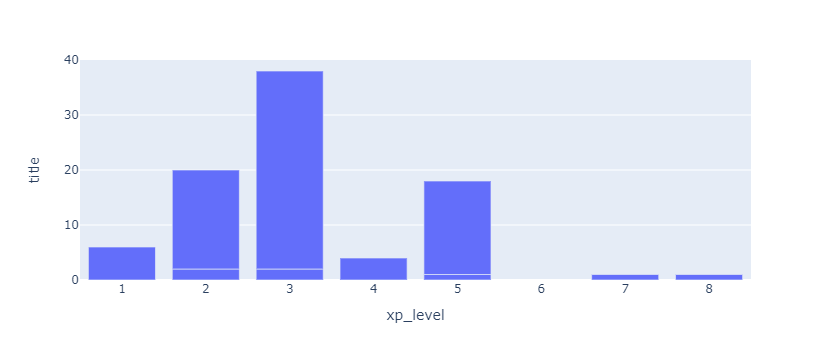

In [704]:
dfg = df.groupby('xp_level').count().reset_index()
# plot structure
fig = px.bar(dfg,
             x='xp_level',
             y='title',
             title='',
             barmode='stack')

# plot
fig.show()